<a href="https://colab.research.google.com/github/EfeKaramese/Breast-Cancer-Prediction-With-ML/blob/main/amazonreview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 33.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import re
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
#Dataset url
url = "https://huggingface.co/datasets/mteb/amazon_reviews_multi/resolve/refs%2Fconvert%2Fparquet/en/train/0000.parquet"

df = pd.read_parquet(url)

In [4]:
# label_text feature is unnecessary
df = df.drop("label_text", axis = True)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
#we do not have test set so we creating it.
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42, stratify = df["label"])

In [7]:
#Data Preprocessing
def simple_preprocess(text):
  text = text.lower()
  text = re.sub(r'[^a-z\s]', '', text)
  return text.split()

train_df["cleaned_tokens"] = train_df["text"].apply(simple_preprocess)
test_df["cleaned_tokens"] = test_df["text"].apply(simple_preprocess)

train_sentences = train_df["cleaned_tokens"].tolist()
test_sentences = test_df["cleaned_tokens"].tolist()


In [8]:
#Creating Word2Vec model.
w2v_model = Word2Vec(sentences = train_sentences, vector_size = 250, window = 8, min_count = 7, sg = 1, workers = 2, epochs = 10)

### Semantic Similarity & Embedding Space Analysis

In [9]:
# Analysing words with strong sentiment polarity
print("Words similar to \"Bad\":")
print(w2v_model.wv.most_similar("bad", topn=5))

print("\nWords similar to \"Good\":")
print(w2v_model.wv.most_similar("good", topn=5))

#Cosine similarity score between "Good" and "Bad" words
score = w2v_model.wv.similarity("good", "bad")
print(f"Good and Bad similarity: {score}")

Words similar to "Bad":
[('terrible', 0.5633228421211243), ('good', 0.5303466320037842), ('horrible', 0.524215042591095), ('poor', 0.5049318671226501), ('unlucky', 0.4290018677711487)]

Words similar to "Good":
[('great', 0.7149861454963684), ('decent', 0.6236459016799927), ('nice', 0.5992895364761353), ('bargin', 0.5459378957748413), ('bad', 0.5303467512130737)]
Good and Bad similarity: 0.530346691608429


In [10]:
# dictionary containing all words( word to index)
# We are setting the first index to 0.
word2idx = {word: i+1 for i, word in enumerate(w2v_model.wv.index_to_key)}
word2idx["<PAD>"] = 0  # zeros to fill in the blanks
word2idx["<UNK>"] = len(word2idx) # For unknown words

In [11]:
#After training our Word2Vec model, we need to represent our text data in a format that the Bi-LSTM network can process.
#Tokenization
def sentence_to_ids(tokens, word2idx, max_len=50):
    ids = [word2idx.get(token, word2idx["<UNK>"]) for token in tokens]
    if len(ids) < max_len:
        ids += [0] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids


X_train = [sentence_to_ids(sent, word2idx) for sent in train_sentences]
X_test = [sentence_to_ids(sent, word2idx) for sent in test_sentences]

In [12]:
#Create the Embedding Matrix
vocab_size = len(word2idx)
embedding_dim = 250
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word2idx.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
    elif word == "<PAD>":
        embedding_matrix[i] = np.zeros(embedding_dim)
    else: # random initalization for <UNK> situataions
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

#Transform to Tensor
embedding_weights = torch.FloatTensor(embedding_matrix)

In [13]:
#transform stars into sentiments
def map_sentiment(label):
    if label <= 1:
        return 0  # Bad
    elif label == 2:
        return 1  # Neutral
    else:
        return 2  # Good


train_df['three_labels'] = train_df['label'].apply(map_sentiment)
test_df['three_labels'] = test_df['label'].apply(map_sentiment)


In [14]:
# One hot encoding
y_train_tensor = F.one_hot(torch.tensor(train_df['three_labels'].values), num_classes=3)
y_test_tensor = F.one_hot(torch.tensor(test_df['three_labels'].values), num_classes=3)

In [15]:
train_data = TensorDataset(torch.LongTensor(X_train), y_train_tensor)
test_data = TensorDataset(torch.LongTensor(X_test), y_test_tensor)

batch_size = 128

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [16]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_weights):
        super(SentimentLSTM, self).__init__()

        #Embedding Layer. Converts word IDs into dense vectors using pre-trained Word2Vec weights to capture semantic meaning.
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(embedding_weights) # Ağırlıkları buraya yükledik
        self.embedding.weight.requires_grad = True # Model eğitilirken bu ağırlıklar da güncellensin (Seçenek B)

        #Bidirectional LSTM Layers. Processes sequences in both directions to understand the full context of a review.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = 2,batch_first=True, bidirectional= True, dropout = 0.3)

        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)

        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)

        #Output Layer
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))

        # LSTM outputs
        lstm_out, (hidden, cell) = self.lstm(embedded)

        # Merging last hidden states
        hidden_combined = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

        out = self.batch_norm(hidden_combined)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)

        return self.fc2(out)

In [29]:
hidden_dim = 256
output_dim = 3

model = SentimentLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_weights).to(device)
model =  model.to(device)

weights = torch.tensor([1.0, 2.5, 1.0], dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

print(model)

SentimentLSTM(
  (embedding): Embedding(14503, 250)
  (lstm): LSTM(250, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (batch_norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)


In [30]:
#train and evaluation functions
def train_model(model, train_loader, test_loader, epochs=10, patience = 2):
  # history dict for visualizations and performance tracking
  history = {
        'train_loss': [],
        'test_loss': [],
        'test_acc': []
    }

  scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

  best_test_loss = float('inf')
  early_stop_counter = 0

  for epoch in range(epochs):
      model.train()
      train_loss = 0
      loop = tqdm(train_loader, leave=True, mininterval = 10)
      for inputs, labels in loop:
          inputs, labels = inputs.to(device), labels.to(device).float()

          optimizer.zero_grad()

          outputs = model(inputs)

          loss = criterion(outputs, labels)

          loss.backward()

          optimizer.step()

          train_loss += loss.item()

          loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
          loop.set_postfix(loss=loss.item())

      avg_train_loss = train_loss / len(train_loader)
      test_loss, test_acc = evaluate(model, test_loader, criterion)

      history['train_loss'].append(avg_train_loss)
      history['test_loss'].append(test_loss)
      history['test_acc'].append(test_acc)

      print(f"\n--- Epoch {epoch+1} Summary ---")
      print(f"Train Loss: {train_loss/len(train_loader):.4f}")
      print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

      #Early stopping
      if test_loss < best_test_loss:
            best_test_loss = test_loss
            early_stop_counter = 0
      else:
          early_stop_counter += 1
          print(f" No improvement on model {early_stop_counter}/{patience}")

      scheduler.step(test_loss)

      if early_stop_counter >= patience:
          print("\n!!! EARLY STOPPING")
          break

  return history

def evaluate(model, loader, criterion):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            _, targets = torch.max(labels, 1)

            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [32]:
EPOCHS = 10

print(f"Training begins")

history = train_model(model, train_loader, test_loader, epochs=EPOCHS)

Training begins


Epoch [1/10]: 100%|██████████| 1250/1250 [00:50<00:00, 24.58it/s, loss=0.571]



--- Epoch 1 Summary ---
Train Loss: 0.4982
Test Loss: 0.5189 | Test Acc: 78.37%


Epoch [2/10]: 100%|██████████| 1250/1250 [00:51<00:00, 24.44it/s, loss=0.349]



--- Epoch 2 Summary ---
Train Loss: 0.4935
Test Loss: 0.5346 | Test Acc: 77.72%
 No improvement on model 1/2


Epoch [3/10]: 100%|██████████| 1250/1250 [00:50<00:00, 24.68it/s, loss=0.602]



--- Epoch 3 Summary ---
Train Loss: 0.4866
Test Loss: 0.5217 | Test Acc: 78.21%
 No improvement on model 2/2

!!! EARLY STOPPING


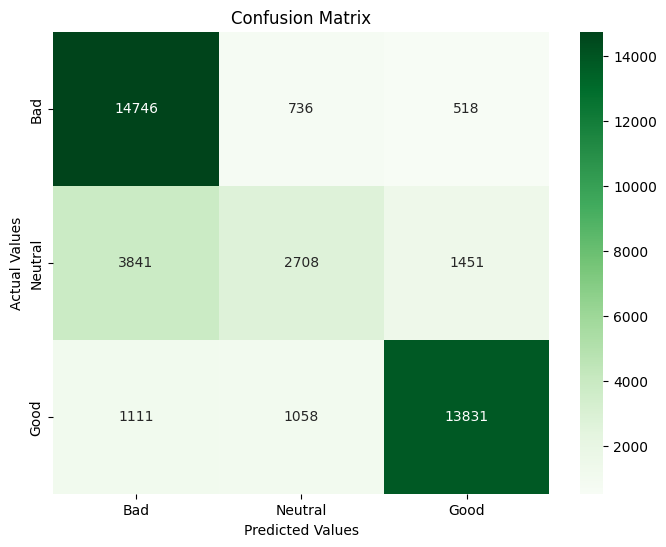

              precision    recall  f1-score   support

         Bad       0.75      0.92      0.83     16000
     Neutral       0.60      0.34      0.43      8000
        Good       0.88      0.86      0.87     16000

    accuracy                           0.78     40000
   macro avg       0.74      0.71      0.71     40000
weighted avg       0.77      0.78      0.77     40000



In [33]:

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_true_arr = np.array(y_true)
y_pred_arr = np.array(y_pred)

if y_true_arr.ndim > 1:
    y_true_indices = np.argmax(y_true_arr, axis=1)
else:
    y_true_indices = y_true_arr

# Confusion Matrix
cm = confusion_matrix(y_true_indices, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Bad', 'Neutral', 'Good'],
            yticklabels=['Bad', 'Neutral', 'Good'])
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true_indices, y_pred, target_names=['Bad', 'Neutral', 'Good']))

In [34]:
#test function
def predict(text):
    tokens = text.lower().split()
    ids = sentence_to_ids(tokens, word2idx, max_len=50)
    input_tensor = torch.LongTensor([ids]).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)

    labels = {0: "Negative ", 1: "Neutral", 2: "Positive"}
    return labels[pred.item()]

# TEST
print(f"Test 1: {predict('This is the best item I have ever seen!')}")
print(f"Test 2: {predict('It was not that bad, but could be better.')}")
print(f"Test 3: {predict('Standard service, nothing special.')}")

Test 1: Positive
Test 2: Neutral
Test 3: Negative 


###Data Visualizations

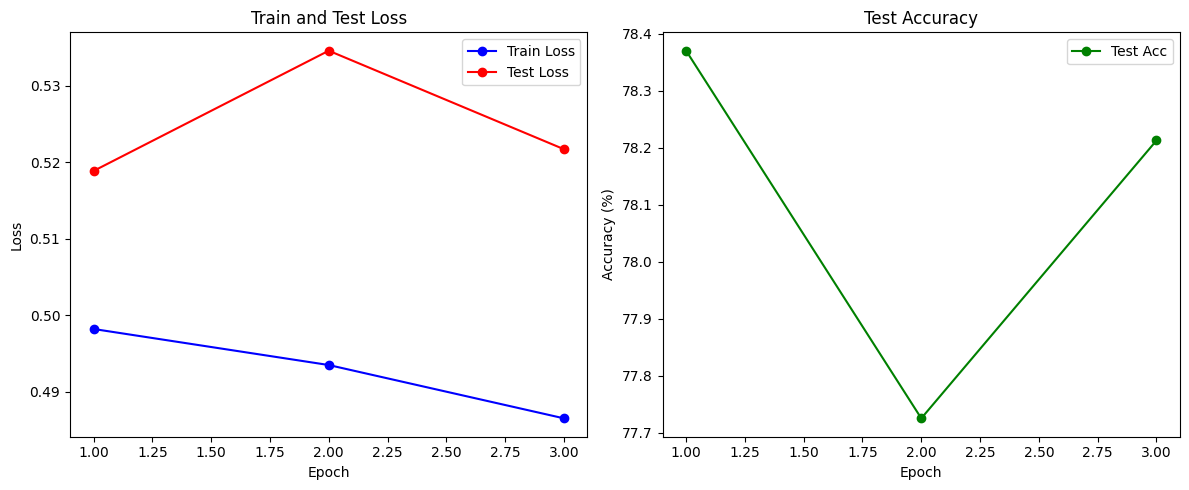

In [35]:
def plot_learning_curves(train_losses, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Graphic
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-o', label='Train Loss')
    plt.plot(epochs, test_losses, 'r-o', label='Test Loss')
    plt.title('Train and Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Graphic
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies, 'g-o', label='Test Acc')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history['train_loss'], history['test_loss'], history['test_acc'])
